In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import IsolationForest
from imblearn.combine import SMOTETomek 
from imblearn.ensemble import RUSBoostClassifier, BalancedRandomForestClassifier, BalancedBaggingClassifier

##### Reading Training and Testing Dataset although we do not have labels on test so we will mainly focus on train.csv

In [2]:
train  = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
# train.head()

##### Check the details about each column

In [4]:
# train.info()

##### get the numeric columns to remove outliers by sklearn's Isolationforest

In [5]:
numCols = [i for i in train.columns if train[i].dtypes != "object"]

x = IsolationForest()
train["outlier"] = x.fit_predict(train[numCols])
train = train[train["outlier"] == 1]
train = train.drop("outlier", axis = 1)

##### Plot the Imbalance

Total Number of Customer Exited 493
Total Number of Customer Stayed 3409


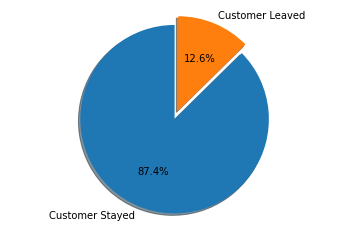

In [6]:
# First Lets Convert the churn column to numeric

train.churn = train.churn.apply(lambda x:0 if x == "no" else 1)

print("Total Number of Customer Exited", len(train[train.churn == 1]))
print("Total Number of Customer Stayed", len(train[train.churn == 0]))

labels = "Customer Stayed", "Customer Leaved"
sizes = [len(train[train.churn == 0]), len(train[train.churn == 1])]
explode = (0, 0.1) 

fig1, ax1 = plt.subplots()

ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')

plt.show()

##### get the categorical columns to convert it to numeric

In [7]:
## Lets Find out the column which are not numeric and we need to convert that to numeric
categoricalColumns = []
for col in train.columns:
    if train[col].dtypes == "object":
        print("Column Name -->", col)
        print("Total Unique Values in this column -->", len(train[col].unique()))
        print("Unique Variable Name -->", train[col].unique())
        print("-" * 75)
        categoricalColumns.append(col)

Column Name --> state
Total Unique Values in this column --> 51
Unique Variable Name --> ['OH' 'NJ' 'OK' 'MO' 'LA' 'IN' 'RI' 'IA' 'MT' 'VA' 'TX' 'FL' 'SC' 'WY'
 'HI' 'NH' 'AZ' 'MA' 'AK' 'GA' 'AR' 'ID' 'WI' 'OR' 'MI' 'DE' 'UT' 'CO'
 'CA' 'SD' 'NC' 'WA' 'MN' 'NM' 'NV' 'DC' 'MD' 'WV' 'VT' 'KY' 'ME' 'MS'
 'AL' 'NE' 'NY' 'TN' 'IL' 'KS' 'PA' 'ND' 'CT']
---------------------------------------------------------------------------
Column Name --> area_code
Total Unique Values in this column --> 3
Unique Variable Name --> ['area_code_415' 'area_code_408' 'area_code_510']
---------------------------------------------------------------------------
Column Name --> international_plan
Total Unique Values in this column --> 2
Unique Variable Name --> ['no' 'yes']
---------------------------------------------------------------------------
Column Name --> voice_mail_plan
Total Unique Values in this column --> 2
Unique Variable Name --> ['yes' 'no']
--------------------------------------------------------

##### We are using ordinal encoding

In [8]:
encoder = OrdinalEncoder()
train[categoricalColumns] = encoder.fit_transform(train[categoricalColumns])
test[categoricalColumns] = encoder.transform(test[categoricalColumns])

In [9]:
train.head()

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,35.0,107,1.0,0.0,1.0,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
1,31.0,137,1.0,0.0,0.0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
3,36.0,75,1.0,1.0,0.0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0
5,24.0,147,1.0,1.0,0.0,0,157.0,79,26.69,103.1,94,8.76,211.8,96,9.53,7.1,6,1.92,0,0
6,18.0,117,0.0,0.0,0.0,0,184.5,97,31.37,351.6,80,29.89,215.8,90,9.71,8.7,4,2.35,1,0


##### scaling the data by MinMax Scaler

In [10]:
scaleColumns = []
for col in train.columns:
    if len(train[col].unique()) > 3:
        scaleColumns.append(col)

scaler = MinMaxScaler()
train[scaleColumns] = scaler.fit_transform(train[scaleColumns])
test[scaleColumns] = scaler.fit_transform(test[scaleColumns])

In [11]:
train.head()

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,0.70,0.438017,1.0,0.0,1.0,0.52,0.467999,0.745455,0.467973,0.525964,0.579618,0.525902,0.621840,0.510949,0.622236,0.695431,0.166667,0.695489,0.125,0
1,0.62,0.561983,1.0,0.0,0.0,0.00,0.704894,0.690909,0.704940,0.300334,0.624204,0.300107,0.374933,0.518248,0.375374,0.619289,0.277778,0.618421,0.000,0
3,0.72,0.305785,1.0,1.0,0.0,0.00,0.482769,0.684848,0.482794,0.382630,0.700637,0.382637,0.440290,0.642336,0.440526,0.512690,0.166667,0.513158,0.375,0
5,0.48,0.603306,1.0,1.0,0.0,0.00,0.454677,0.478788,0.454685,0.245369,0.522293,0.245088,0.507262,0.459854,0.507472,0.360406,0.333333,0.360902,0.000,0
6,0.36,0.479339,0.0,0.0,0.0,0.00,0.534318,0.587879,0.534412,1.000000,0.433121,1.000000,0.518020,0.416058,0.518231,0.441624,0.222222,0.441729,0.125,0


##### Split data into train and test dataset

In [12]:
X_train, X_test, y_train, y_test = train_test_split(train.drop("churn", axis = 1),
                                                   train.churn,
                                                   stratify=train.churn,
                                                   random_state=4,
                                                   test_size=0.25)

##### for oversampling we are using SMOTETomek by imblearn

In [13]:
smt = SMOTETomek(random_state=4)
X_res, y_res = smt.fit_resample(X_train, y_train)

##### Model we are using here is RandomForest which is tweaked for handeling imbalanced data

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       853
           1       0.81      0.78      0.80       123

    accuracy                           0.95       976
   macro avg       0.89      0.88      0.88       976
weighted avg       0.95      0.95      0.95       976



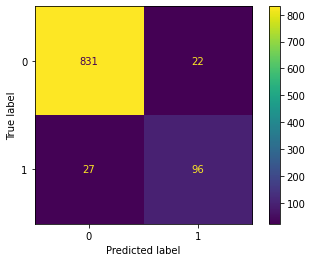

In [14]:
eec = BalancedRandomForestClassifier(random_state=42)
eec.fit(X_res, y_res) 

y_pred = eec.predict(X_test)

print(classification_report(y_test, y_pred))
cf = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(cf)
disp.plot()

In [15]:
# X = train.drop("churn", axis = 1)
# y = train.churn

# smt = SMOTETomek()
# X_res1, y_res1 = smt.fit_resample(X, y)

# FinalModel = BalancedRandomForestClassifier()
# FinalModel.fit(X_res1, y_res1) 

In [16]:
# prediction = FinalModel.predict(test.drop("id", axis = 1))

# test1 = test.copy()

# test1["churn"] = prediction
# test1["churn"] = test1["churn"].apply(lambda x: "no" if x == 0 else "yes")
# test_submit = test1[["id", "churn"]]

# test_submit.to_csv("pred.csv", index = False)

### H2O AutoML

In [17]:
import h2o
from h2o.automl import H2OAutoML

##### Need to init h2o instance to use h2o library

In [18]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.311-b11, mixed mode)
  Starting server from C:\Users\praja\anaconda3\envs\kp0\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\praja\AppData\Local\Temp\tmpprzqy5jv
  JVM stdout: C:\Users\praja\AppData\Local\Temp\tmpprzqy5jv\h2o_praja_started_from_python.out
  JVM stderr: C:\Users\praja\AppData\Local\Temp\tmpprzqy5jv\h2o_praja_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.34.0.3
H2O_cluster_version_age:,1 month and 14 days
H2O_cluster_name:,H2O_from_python_praja_e14ap3
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.061 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,16
H2O_cluster_status:,"locked, healthy"


##### Split data into train and test

In [19]:
X_train, X_test = train_test_split(train, stratify=train.churn,
                                                   random_state=4,
                                                   test_size=0.25)

##### AutoML Started and getting top models which performed best

In [20]:
trainh2o = h2o.H2OFrame(X_train)
testh2o = h2o.H2OFrame(X_test)

# Identify predictors and response
x = trainh2o.columns
y = "churn"
x.remove(y)

# For binary classification, response should be a factor
trainh2o[y] = trainh2o[y].asfactor()

# Run AutoML for 20 base models
aml = H2OAutoML(max_models=10)
aml.train(x=x, y=y, training_frame=trainh2o, validation_frame = testh2o)

# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
12:31:54.122: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.
12:31:54.132: AutoML: XGBoost is not available; skipping it.
12:31:54.175: Step 'best_of_family_xgboost' not defined in provider 'StackedEnsemble': skipping it.
12:31:54.175: Step 'all_xgboost' not defined in provider 'StackedEnsemble': skipping it.

███████████████████████████████████████████████████████████████| (done) 100%


model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
GBM_5_AutoML_1_20211121_123154,0.909293,0.156753,0.838394,0.12845,0.192004,0.0368654
StackedEnsemble_BestOfFamily_3_AutoML_1_20211121_123154,0.908047,0.154296,0.839468,0.125943,0.190775,0.0363951
StackedEnsemble_BestOfFamily_5_AutoML_1_20211121_123154,0.905429,0.155231,0.838686,0.128255,0.19105,0.0365003
GBM_4_AutoML_1_20211121_123154,0.904962,0.160427,0.844935,0.112643,0.19101,0.0364847
StackedEnsemble_AllModels_2_AutoML_1_20211121_123154,0.904067,0.150384,0.84603,0.122262,0.186281,0.0347005
StackedEnsemble_AllModels_5_AutoML_1_20211121_123154,0.903902,0.150487,0.846992,0.125534,0.186178,0.0346623
GBM_grid_1_AutoML_1_20211121_123154_model_1,0.903626,0.159425,0.848972,0.119382,0.189024,0.0357302
StackedEnsemble_BestOfFamily_2_AutoML_1_20211121_123154,0.902429,0.156814,0.844644,0.115524,0.189483,0.0359037
StackedEnsemble_AllModels_3_AutoML_1_20211121_123154,0.901646,0.150445,0.847261,0.120715,0.185618,0.034454
GBM_2_AutoML_1_20211121_123154,0.901451,0.158319,0.840183,0.119773,0.190904,0.0364442


##### Check each model with more details

In [21]:
lb = h2o.automl.get_leaderboard(aml, extra_columns = "ALL")
lb

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse,training_time_ms,predict_time_per_row_ms,algo
GBM_5_AutoML_1_20211121_123154,0.909293,0.156753,0.838394,0.12845,0.192004,0.0368654,196,0.008311,GBM
StackedEnsemble_BestOfFamily_3_AutoML_1_20211121_123154,0.908047,0.154296,0.839468,0.125943,0.190775,0.0363951,721,0.00898,StackedEnsemble
StackedEnsemble_BestOfFamily_5_AutoML_1_20211121_123154,0.905429,0.155231,0.838686,0.128255,0.19105,0.0365003,584,0.008535,StackedEnsemble
GBM_4_AutoML_1_20211121_123154,0.904962,0.160427,0.844935,0.112643,0.19101,0.0364847,234,0.00995,GBM
StackedEnsemble_AllModels_2_AutoML_1_20211121_123154,0.904067,0.150384,0.84603,0.122262,0.186281,0.0347005,720,0.011734,StackedEnsemble
StackedEnsemble_AllModels_5_AutoML_1_20211121_123154,0.903902,0.150487,0.846992,0.125534,0.186178,0.0346623,716,0.013539,StackedEnsemble
GBM_grid_1_AutoML_1_20211121_123154_model_1,0.903626,0.159425,0.848972,0.119382,0.189024,0.0357302,222,0.010139,GBM
StackedEnsemble_BestOfFamily_2_AutoML_1_20211121_123154,0.902429,0.156814,0.844644,0.115524,0.189483,0.0359037,1245,0.011848,StackedEnsemble
StackedEnsemble_AllModels_3_AutoML_1_20211121_123154,0.901646,0.150445,0.847261,0.120715,0.185618,0.034454,715,0.015976,StackedEnsemble
GBM_2_AutoML_1_20211121_123154,0.901451,0.158319,0.840183,0.119773,0.190904,0.0364442,212,0.008256,GBM


##### evaluating the best model on our test data

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       853
           1       0.91      0.72      0.81       123

    accuracy                           0.96       976
   macro avg       0.93      0.86      0.89       976
weighted avg       0.95      0.96      0.95       976



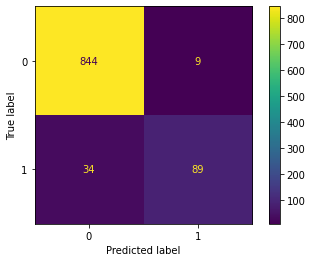

In [22]:
preds = aml.leader.predict(testh2o)
churnh2o = preds["predict"].as_data_frame().to_numpy().reshape(1,-1)[0]

print(classification_report(y_test, churnh2o))
cf = confusion_matrix(y_test, churnh2o)

disp = ConfusionMatrixDisplay(cf)
disp.plot()

# test1 = test.copy()

# test1["churn"] = preds["predict"].as_data_frame().to_numpy().reshape(1,-1)[0]

# test1["churn"] = test1["churn"].apply(lambda x: "no" if x == 0 else "yes")
# test_submit = test1[["id", "churn"]]

# test_submit.to_csv("predh2o.csv", index = False)

##### Evaluating other top models on test dataset -- Please Check the model name in leaderboard it might change in yours

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       853
           1       0.84      0.82      0.83       123

    accuracy                           0.96       976
   macro avg       0.91      0.90      0.90       976
weighted avg       0.96      0.96      0.96       976



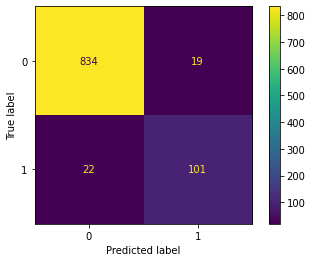

In [24]:
m = h2o.get_model("DRF_1_AutoML_1_20211121_123154") ## Change the model name according to yours autoML result
preds = m.predict(testh2o)

churnh2o = preds["predict"].as_data_frame().to_numpy().reshape(1,-1)[0]

print(classification_report(y_test, churnh2o))
cf = confusion_matrix(y_test, churnh2o)

disp = ConfusionMatrixDisplay(cf)
disp.plot()


# test1 = test.copy()

# test1["churn"] = preds["predict"].as_data_frame().to_numpy().reshape(1,-1)[0]

# test1["churn"] = test1["churn"].apply(lambda x: "no" if x == 0 else "yes")
# test_submit = test1[["id", "churn"]]

# test_submit.to_csv("predh2o2.csv", index = False)